# 不均衡データの画像の解析手法に決着つけたい

- cifar10のデータセットで試した。
- under smapling と over sampling を試した
    - class wheight は over samplingよりも収束が早くなっても精度は落ちることが明白なのでやらない
    
### under sampling 
- at random
- under sampling with PCA
- under sampling with high confidence
- remove high confidence
- mixed with low and high confidence

### over sampling
- without augmentation
- with augmentation

In [296]:
from keras.datasets import cifar10
from farmer.Classifier import Classifier

from ncc.history import show_history
from ncc.metrics import show_matrix
from ncc.models import Model2D

from sklearn.metrics import recall_score, precision_score

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [122]:
label_thresh = [5000 - i*500 for i in range(10)]
label_count = [0 for _ in range(10)]

In [123]:
u_image, u_label = [], []
for image, label in zip(x_train, y_train.ravel()):
    if label_count[label] < label_thresh[label]:
        label_count[label] += 1
        
        u_image.append(image)
        u_label.append(label)

(array([5000., 4500., 4000., 3500., 3000., 2500., 2000., 1500., 1000.,
         500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

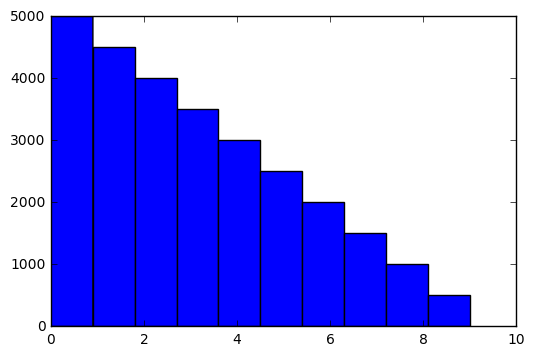

In [124]:
plt.hist(u_label)

## base line

(27500, 32, 32, 3) (27500, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)    

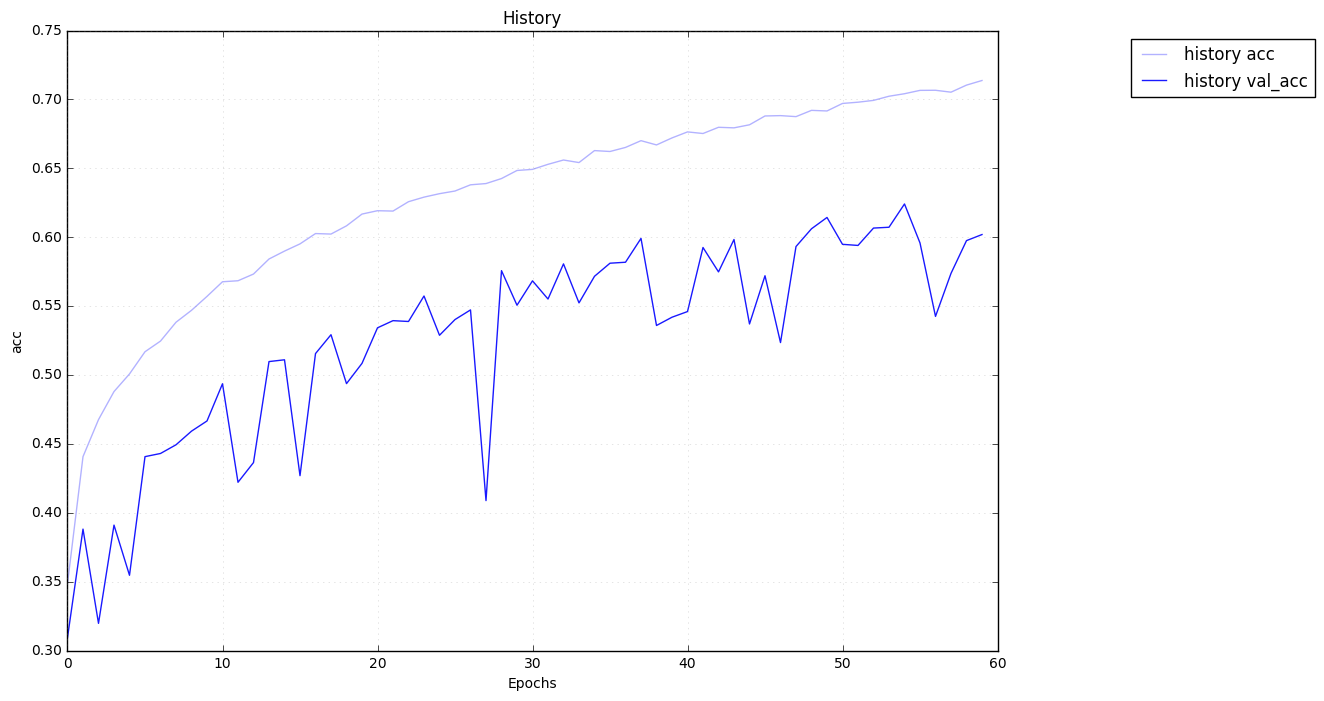

Confusion matrix, without normalization
[[808  23  61  47  23   6   9   7  13   3]
 [ 27 887  17  34   6   6  13   0   3   7]
 [ 72   6 622 100  74  51  61  11   3   0]
 [ 27  11  83 618  56 128  65  12   0   0]
 [ 26   5 110 122 590  31  88  25   3   0]
 [ 11   2  94 287  54 500  26  23   3   0]
 [  6   3  72  86  29  12 790   1   1   0]
 [ 23  10  71 137 100 120  16 521   1   1]
 [260 131  34  65  14  10  14   2 466   4]
 [119 472  24  80  22  16  19  20  11 217]]
Normalized confusion matrix


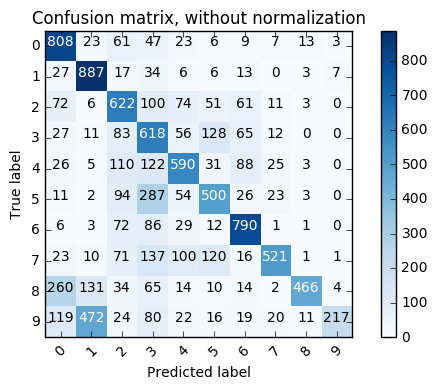

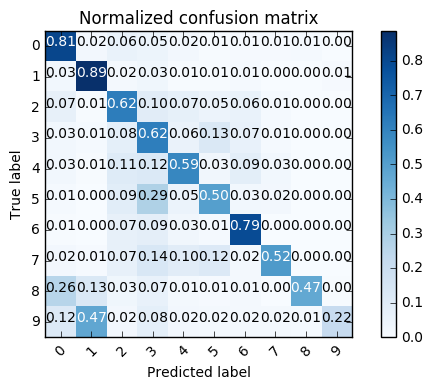

In [8]:
Classifier().fit_from_array(np.array(u_image), np.array(u_label), x_test, y_test)

In [96]:
def test_model(model_path):
    base_model = Model2D(input_shape=(32, 32, 3), num_classes=10)
    base_model.load_weights(model_path)
    y_pred = base_model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    return precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro')

In [97]:
test_model('classification_base_model.h5')

(0.5652498370581558, 0.3223)

## under sampling

## まずは普通にランダムサンプリング

In [44]:
# choice 500 images at random
random_images = []
random_labels = np.concatenate([np.full(500, i) for i in range(10)], axis=0)  # 0,0,0,....1,1,1,2,........9,9,9

for i in range(10):
    cls_index = np.where(np.array(u_label) == i)[0]  # 特定のラベルのindexを取得する
    np.random.shuffle(cls_index)
    cls_image = np.array(u_image)[cls_index[:500]]  # シャッフルした後500枚取り出す
    random_images.append(cls_image)
    
random_images = np.concatenate(random_images, axis=0)

random_index =  np.arange(5000)
np.random.shuffle(random_index)

(5000, 32, 32, 3) (5000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)      

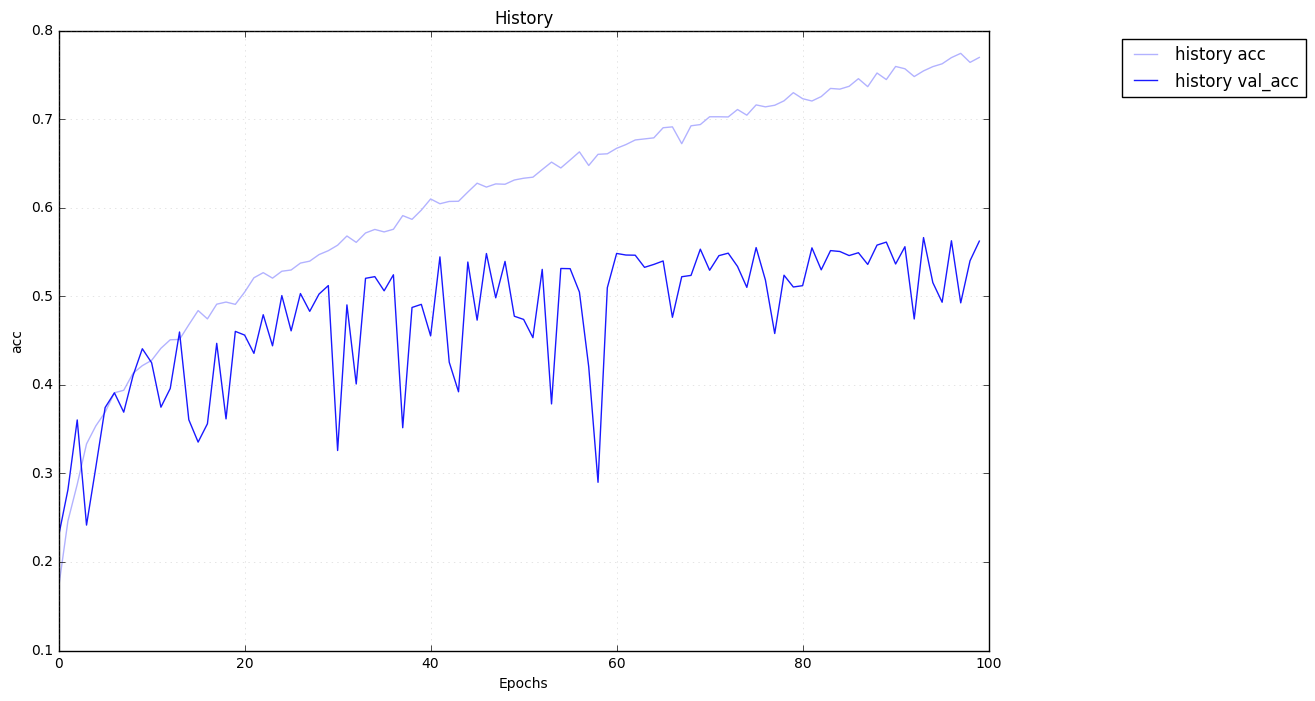

Confusion matrix, without normalization
[[571  53  51  40  14  17  28  19 149  58]
 [ 19 765   5  18   3  10  10  16  34 120]
 [ 71  14 367 127  87 119 112  55  28  20]
 [ 31  26  47 427  45 232 113  39  16  24]
 [ 30   9 100 125 389  93 116 110  20   8]
 [ 18   6  38 236  46 504  51  75  10  16]
 [ 10  11  45 102  47  48 687  21  13  16]
 [ 15  13  27  85  43 129  31 615   6  36]
 [ 79  94  23  20   4  13  10   5 691  61]
 [ 38 182   9  41   2  15  20  33  54 606]]
Normalized confusion matrix


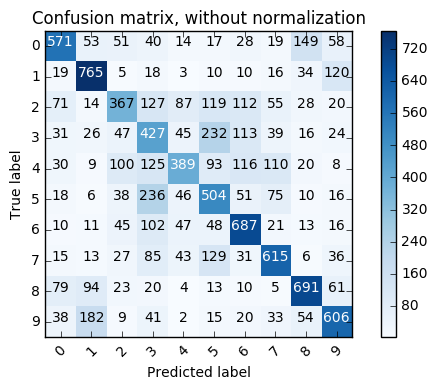

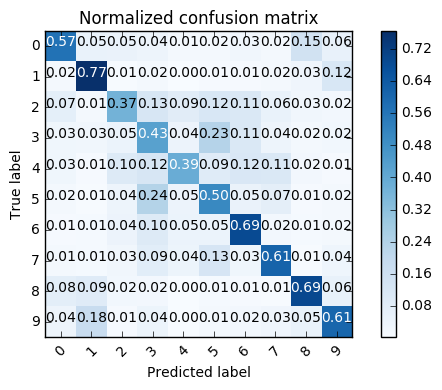

In [60]:
# fit with under sampling !
Classifier(early_stopping=False).fit_from_array(random_images[random_index], random_labels[random_index], x_test, y_test)

In [98]:
test_model('classification_random_model.h5')

(0.40446695539037475, 0.23240000000000002)

## under sampling with PCA

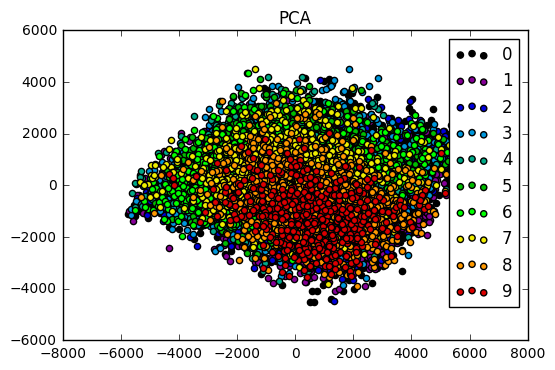

In [162]:
pca_plot = PCA(n_components=2)
flat = np.array(u_image).reshape(27500, 32*32*3)
X_r = pca_plot.fit(flat).transform(flat)

colors = [plt.cm.nipy_spectral(i/10., 1) for i in range(10)]
for i in range(10):
    cls_index = np.where(np.array(u_label) == i)[0]
    plt.scatter(X_r[cls_index][:, 0], X_r[cls_index][:, 1], c=colors[i], label = i)
plt.legend()
plt.title('PCA')

In [163]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
flat = np.array(u_image).reshape(27500, 32*32*3)
pca.fit(flat)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [164]:
# クラスごとに平均をだす
mean_vec = []
for i in range(10):
    cls_index = np.where(np.array(u_label) == i)[0]
    cls_image = np.array(u_image)[cls_index]
    pred = pca.transform(cls_image.reshape(len(cls_image), 32*32*3))
    mean_vec.append(np.average(pred, axis=0))

In [165]:
def trans(cls_image, class_index): 
    transformed_image = pca.transform(cls_image.reshape(len(cls_image), 32*32*3))
    diff_data =  transformed_image - mean_vec[class_index]
    sq_data   = diff_data ** 2
    distance  = sq_data.sum(axis=1)
    return distance

In [169]:
# choice high reliabel images
reliable_images = []
reliable_labels = np.concatenate([np.full(500, i) for i in range(10)], axis=0)  # 0,0,0,....1,1,1,2,........9,9,9

for i in range(10):
    cls_index = np.where(np.array(u_label) == i)[0]
    cls_image = np.array(u_image)[cls_index]
    dist = trans(cls_image, i)
    confidence_index = np.argsort(dist)
    reliable_images.append(cls_image[confidence_index[:500]])

reliable_images = np.concatenate(reliable_images, axis=0)

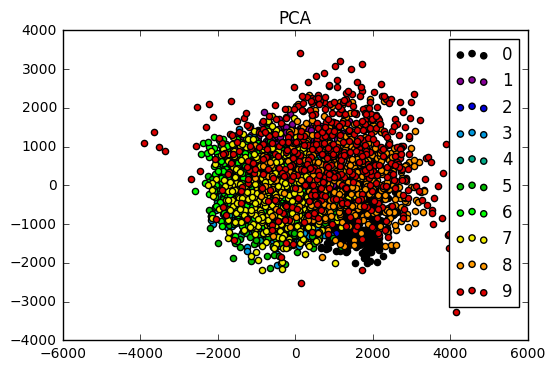

In [170]:
pca_plot = PCA(n_components=2)
flat = np.array(reliable_images).reshape(5000, 32*32*3)
X_r = pca_plot.fit(flat).transform(flat)

colors = [plt.cm.nipy_spectral(i/10., 1) for i in range(10)]
for i in range(10):
    cls_index = np.where(np.array(reliable_labels) == i)[0]
    plt.scatter(X_r[cls_index][:, 0], X_r[cls_index][:, 1], c=colors[i], label = i)
plt.legend()
plt.title('PCA')

In [171]:
random_index =  np.arange(5000)
np.random.shuffle(random_index)

(5000, 32, 32, 3) (5000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1024)      

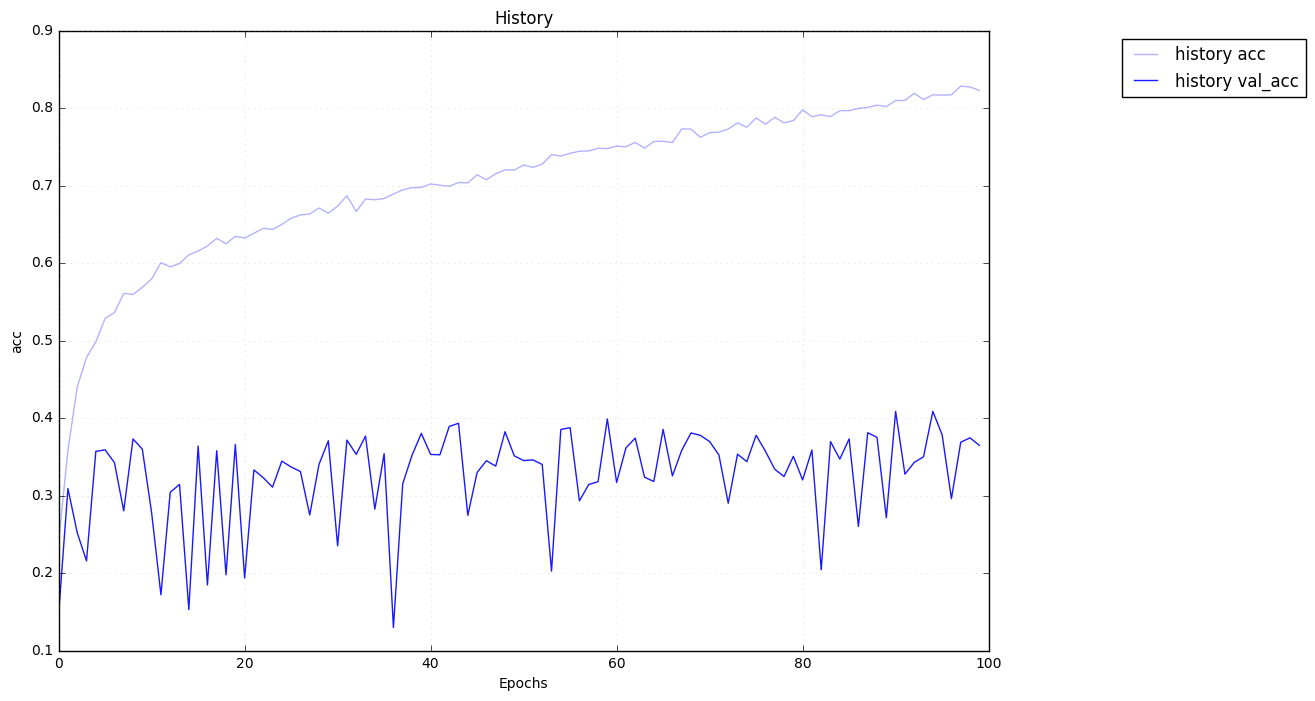

Confusion matrix, without normalization
[[283  38   5   9   3   9   6  19 272 356]
 [ 12 285   1   4   1   4   3   5  62 623]
 [105  18 148 102  31 109  56  69  57 305]
 [ 16  12  16 214   7 141  25  43  39 487]
 [ 52  17  78 120 124 113  86 164  51 195]
 [ 17  16  22 111   4 318  12  82  32 386]
 [ 16  33  31 124  10  55 378  35  21 297]
 [ 15  10   3  35  11  73  13 462  27 351]
 [ 49  33   3  11   0  17   0   4 651 232]
 [  6  92   2   8   0   7   4   8  89 784]]
Normalized confusion matrix


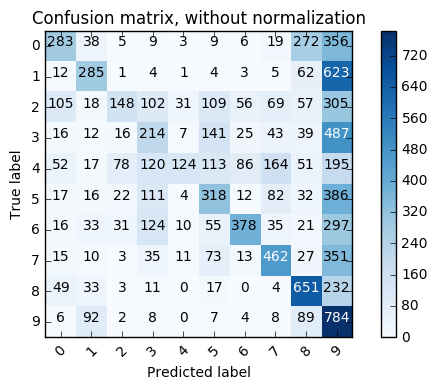

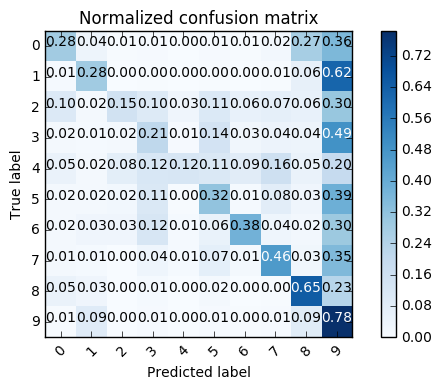

In [172]:
# fit with under sampling !
Classifier(early_stopping=False).fit_from_array(reliable_images[random_index], reliable_labels[random_index], x_test, y_test)

## under sampling with high confidence

(27500, 32, 32, 3) (27500, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1024)    

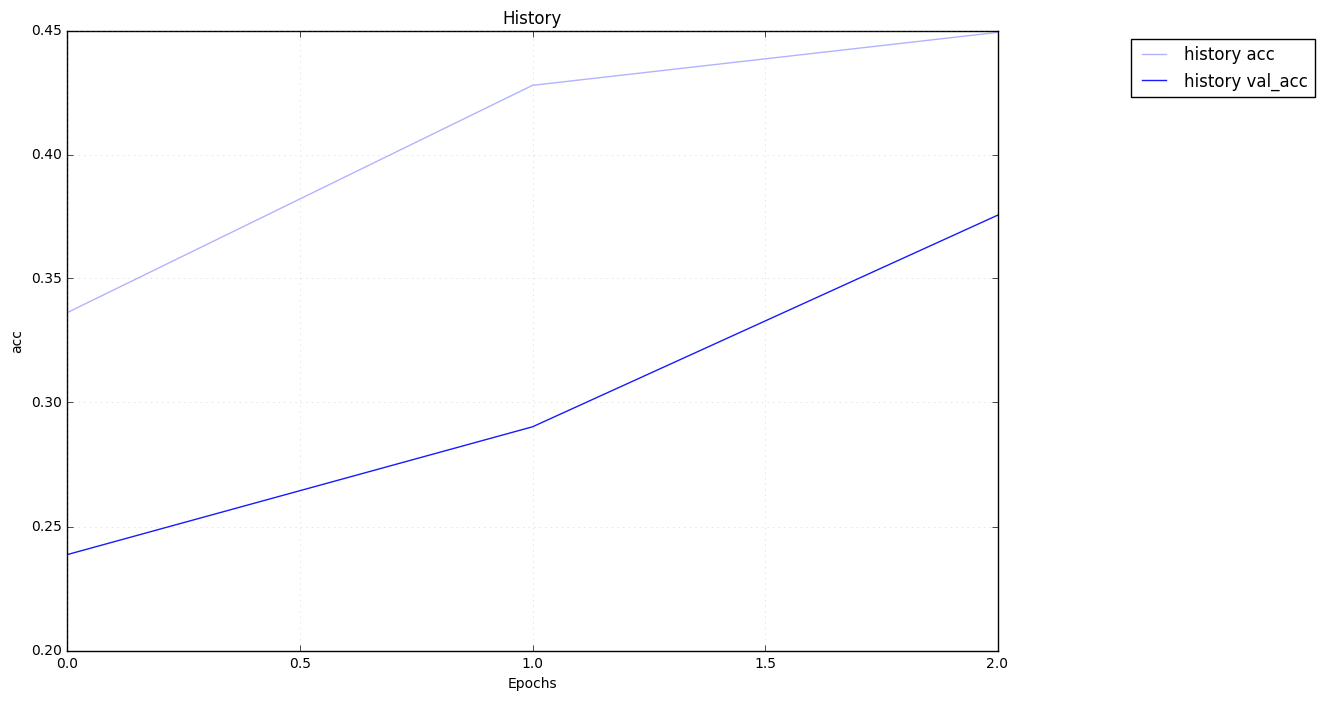

Confusion matrix, without normalization
[[699  84 133  16  19  11  24  11   3   0]
 [109 790  29  28   5   7  24   6   1   1]
 [109  26 586  62 120  32  52  13   0   0]
 [ 38  54 284 294 139  60 119  11   1   0]
 [ 64  15 362  54 370  22  90  23   0   0]
 [ 29  23 347 194 119 174  93  19   2   0]
 [ 15  27 199 101 140  16 494   7   1   0]
 [ 85  57 198  85 192  56  55 272   0   0]
 [604 160  93  28  14  10  10   9  72   0]
 [178 610  60  60  10   3  49  19   7   4]]
Normalized confusion matrix


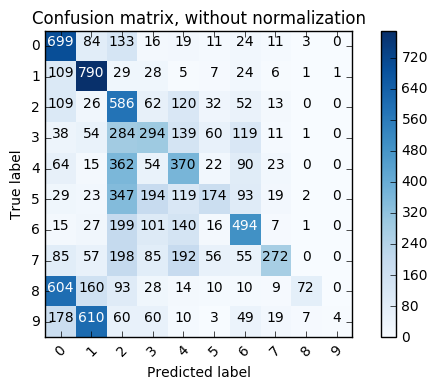

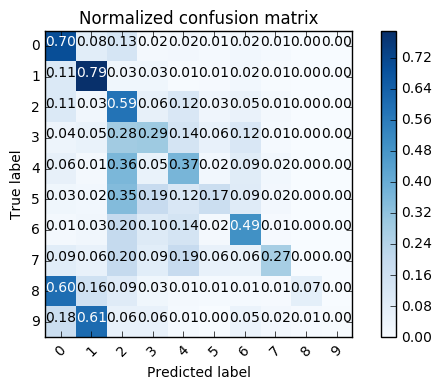

In [174]:
Classifier(epochs=3).fit_from_array(np.array(u_image), np.array(u_label), x_test, y_test)

In [191]:
base_model = Model2D(input_shape=(32, 32, 3), num_classes=10)
base_model.load_weights('classification_first3_model.h5')

# choice high reliabel images
reliable_images = []
reliable_labels = np.concatenate([np.full(500, i) for i in range(10)], axis=0)  # 0,0,0,....1,1,1,2,........9,9,9

for i in range(10):
    cls_index = np.where(np.array(u_label) == i)[0]
    cls_image = np.array(u_image)[cls_index]
    pred = base_model.predict(cls_image)[:, i]
    confidence_index = np.argsort(pred)
    reliable_images.append(cls_image[confidence_index[-500:]])
    
reliable_images = np.concatenate(reliable_images, axis=0)

(5000, 32, 32, 3) (5000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_22 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 1024)      

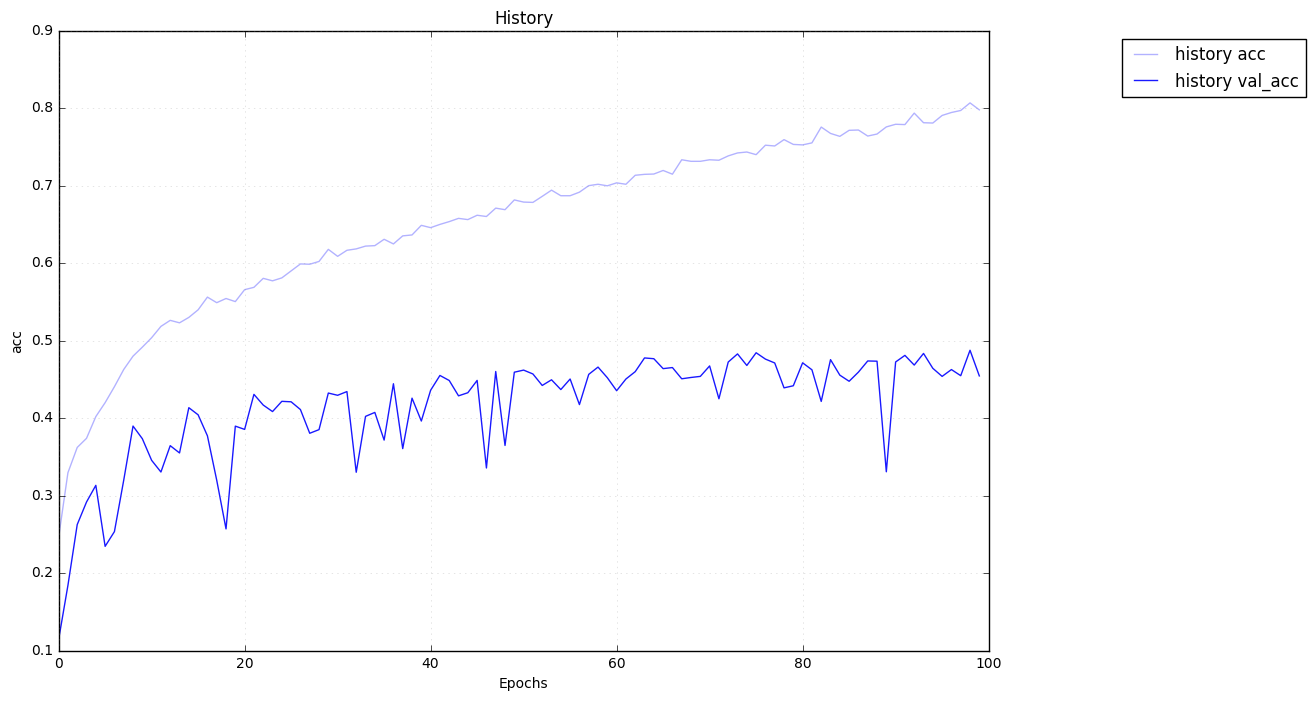

Confusion matrix, without normalization
[[278  73  27  12  52   8   4  89 350 107]
 [  1 674   2   8  10   6   2  50  58 189]
 [ 60  28 206  77 176 120  44 205  51  33]
 [ 22  64  19 256  72 234  37 212  37  47]
 [ 16  17  34  81 378 112  45 259  40  18]
 [  9  23  63 126  82 403  12 229  29  24]
 [  3  35  37 101 131 126 349 161  10  47]
 [  5  32   7  31  47  81   6 728  18  45]
 [ 30  96  13   4  14  10   0  48 706  79]
 [  1 225   3   5  11  14   4  96  76 565]]
Normalized confusion matrix


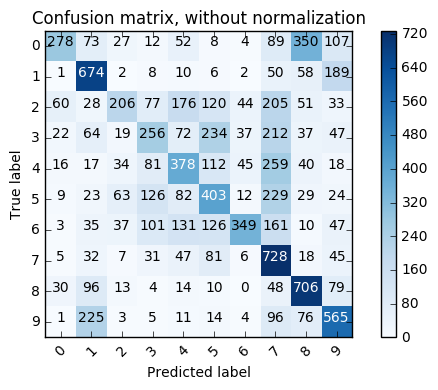

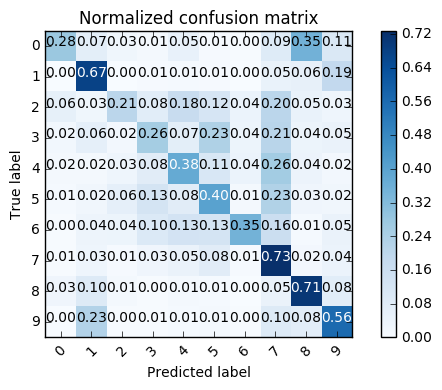

In [195]:
# fit with under sampling !
Classifier(early_stopping=False).fit_from_array(reliable_images[random_index], reliable_labels[random_index], x_test, y_test)

## remove high confidence

In [198]:
base_model = Model2D(input_shape=(32, 32, 3), num_classes=10)
base_model.load_weights('classification_first3_model.h5')

# choice high reliabel images
reliable_images = []
reliable_labels = np.concatenate([np.full(500, i) for i in range(10)], axis=0)  # 0,0,0,....1,1,1,2,........9,9,9

for i in range(10):
    cls_index = np.where(np.array(u_label) == i)[0]
    cls_image = np.array(u_image)[cls_index]
    pred = base_model.predict(cls_image)[:, i]
    confidence_index = np.argsort(pred)
    reliable_images.append(cls_image[confidence_index[:500]])
    
reliable_images = np.concatenate(reliable_images, axis=0)

(5000, 32, 32, 3) (5000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 1024)      

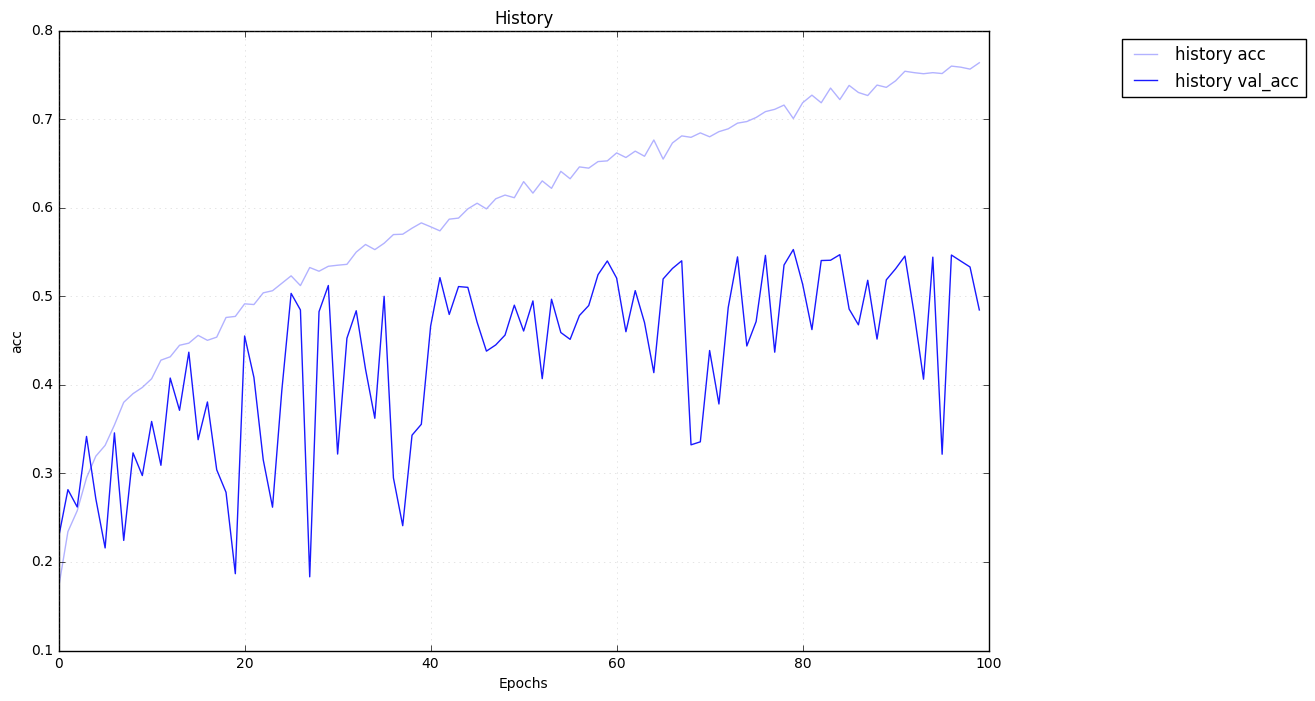

Confusion matrix, without normalization
[[637  22  19   9   2   4   1   1 274  31]
 [142 655   3   4   0   1   2   2  91 100]
 [233  17 411  52  36  65  25  32 104  25]
 [179  40  89 282  43 166  17  39  85  60]
 [185  22 206  53 285  57  23  99  60  10]
 [130  22  92 119  20 405  20  73  80  39]
 [ 98  41 112 114  67  52 383  38  49  46]
 [153  19  48  52  35  61   4 521  33  74]
 [162  36   1   5   0   1   1   2 775  17]
 [187 209   4   8   1   6   1  10  83 491]]
Normalized confusion matrix


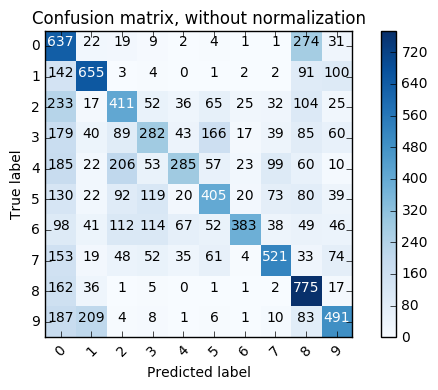

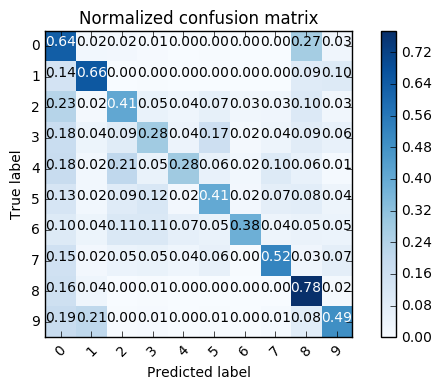

In [199]:
# fit with under sampling !
Classifier(early_stopping=False).fit_from_array(reliable_images[random_index], reliable_labels[random_index], x_test, y_test)

## mixed with low and high confidence 

In [221]:
base_model = Model2D(input_shape=(32, 32, 3), num_classes=10)
base_model.load_weights('classification_first3_model.h5')

# choice high reliabel images
reliable_images = []
reliable_labels = np.concatenate([np.full(500, i) for i in range(10)], axis=0)  # 0,0,0,....1,1,1,2,........9,9,9

for i in range(10):
    cls_index = np.where(np.array(u_label) == i)[0]
    cls_image = np.array(u_image)[cls_index]
    pred = base_model.predict(cls_image)[:, i]
    confidence_index = np.argsort(pred)
    reliable_images.append(cls_image[np.array(list(confidence_index[:250]) + list(confidence_index[-250:]))])
    
reliable_images = np.concatenate(reliable_images, axis=0)

(5000, 32, 32, 3) (5000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_27 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 1024)      

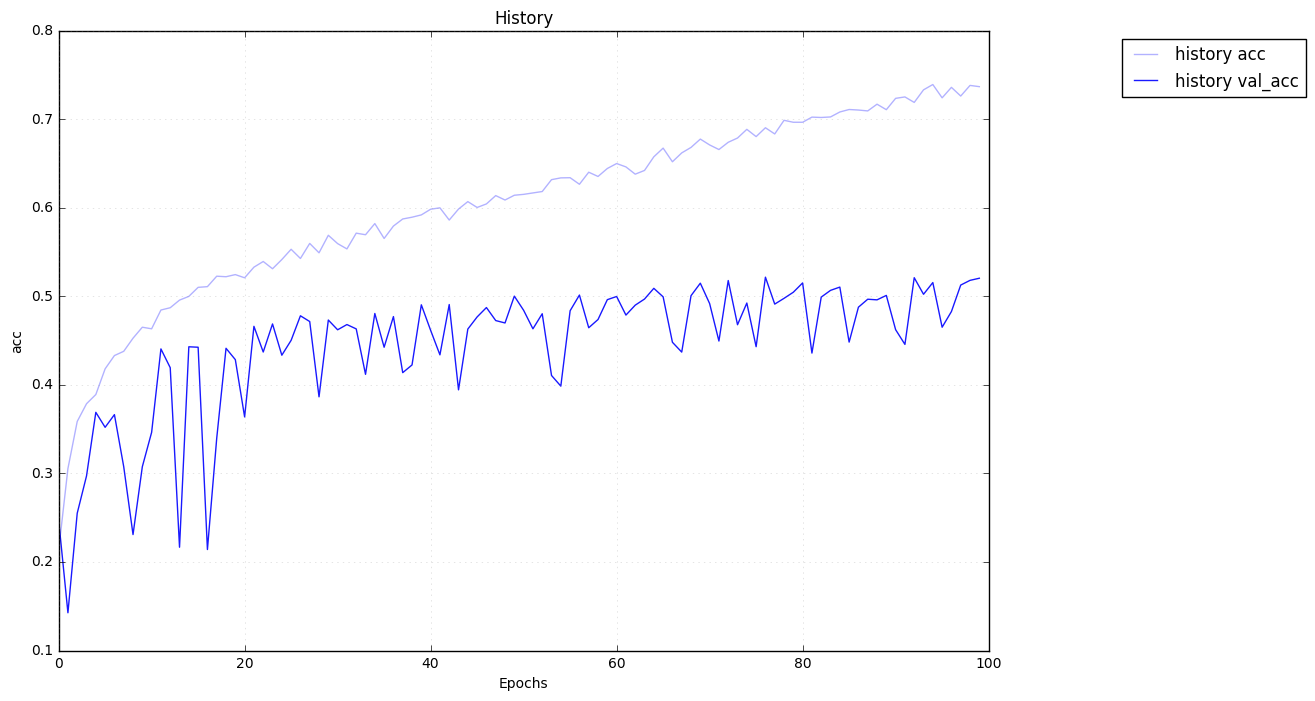

Confusion matrix, without normalization
[[555  65  65  11  34  10  18  32 156  54]
 [ 26 682   6   7   5   6  29  12  68 159]
 [ 92  20 345  58 134  77 145  76  32  21]
 [ 32  43  77 290  84 129 220  58  29  38]
 [ 40  20 108  46 405  45 222  87  20   7]
 [ 18  25 131 144  69 372 110  88  22  21]
 [ 12  19  43  59  47  23 747  23  11  16]
 [ 38  37  53  37  86  78  55 563   9  44]
 [102  88  18   9  14  11  18  13 659  68]
 [ 39 217  10  20  14   8  17  26  64 585]]
Normalized confusion matrix


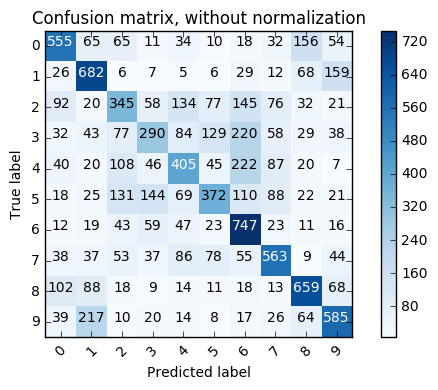

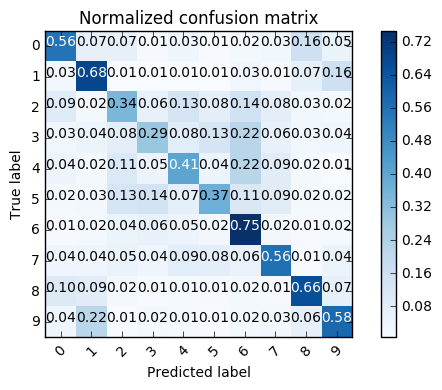

In [222]:
# fit with under sampling !
Classifier(early_stopping=False).fit_from_array(reliable_images[random_index], reliable_labels[random_index], x_test, y_test)

## over sampling

## 均等にover sampling

In [293]:
def generate_arrays_from_file(images, batch_size, index_range):
    while True:
        x, y = [], []
        steps_per_epoch = 5000*100// (batch_size//10)
        for step in range(steps_per_epoch):
            for class_name in range(10):
                for i in range(batch_size // 10):
                    x.append(images[class_name][index_range[class_name][step*10 + i]])
                    y.append(class_name)
            yield np.array(x), np.eye(10)[np.array(y)]
            x, y = [], []

In [309]:
cls_indexes = []
for i in range(10):
    repeat_num = int(5000*100 / label_thresh[i])
    cls_label = []
    for _ in range(repeat_num):
        cls_arange = np.arange(label_thresh[i])
        np.random.shuffle(cls_arange)
        cls_label.append(cls_arange)
    cls_label.append(np.random.randint(0, label_thresh[i], 5000*100 - len(np.concatenate(cls_label))))
    cls_indexes.append(np.concatenate(cls_label))

cls_images = []
for i in range(10):
    cls_label = np.where(np.array(u_label) == i)[0]
    cls_images.append(np.array(u_image)[cls_label])

In [277]:
model = Model2D(input_shape=(32, 32, 3), num_classes=10)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [294]:
model.fit_generator(
    generate_arrays_from_file(
        cls_images, 
        100, 
        cls_indexes
    ), 
    steps_per_epoch=5000*10, epochs=1)

Epoch 1/1
50000/50000 [==============================] - 2087s 42ms/step - loss: 0.9114 - acc: 0.6738


Confusion matrix, without normalization
[[800  30  32  16   5  12   5  10  75  15]
 [ 33 878   8  13   1   5   2   2  25  33]
 [ 87  12 593  65  68  96  42  16  20   1]
 [ 49  22  59 490  43 243  48  22  15   9]
 [ 46   7 101  93 568  62  41  70  11   1]
 [ 22   7  56 171  37 645  11  31  14   6]
 [ 15  10  63  91  53  41 714   4   7   2]
 [ 30  12  42  51  57 115   2 678   5   8]
 [ 83  72  17  23   3   7   2   3 777  13]
 [ 85 273   8  36   4  14   7  15  48 510]]
Normalized confusion matrix


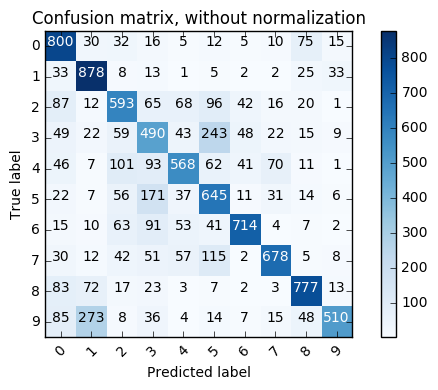

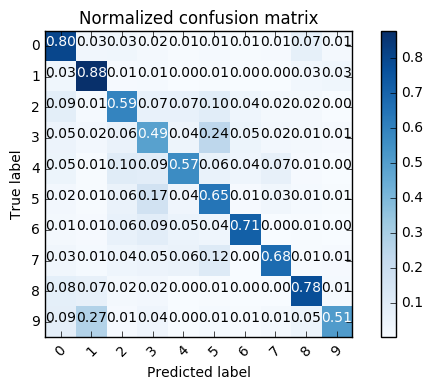

In [298]:
y_prediction = model.predict(x_test)
y_prediction_cls = np.argmax(y_prediction, axis=1)  # from one hot to class index
show_matrix(y_test, y_prediction_cls, [i for i in range(10)])

In [304]:
model.evaluate(x_test, np.eye(10)[y_test.ravel()])

10000/10000 [==============================] - 2s 226us/step


[1.1083340858459472, 0.6653]

## oversampling with data augmentation

In [314]:
import numpy as np
from PIL import Image, ImageEnhance, ImageOps, ImageFilter


def augmentation(image):

    SATURATION = np.random.rand()  # 0.0 ~ 1.0
    CONTRAST = np.random.randint(500, 1000)/1000  # 0.5 ~ 1.0
    BRIGHTNESS = np.random.randint(500, 1000)/1000  # 0.5 ~ 1.0
    SHARPNESS = np.random.randint(0, 2000)/1000  # 0.0 ~ 2.0
    FLIP = np.random.choice([True, False])  # True or False
    MIRROR = np.random.choice([True, False])  # True or False
    BLUR = np.random.randint(0, 1000)/1000  # 0.0 ~ 1.0

    img = Image.fromarray(np.uint8(image))

    # 彩度を変える
    saturation_converter = ImageEnhance.Color(img)
    img = saturation_converter.enhance(SATURATION)

    # コントラストを変える
    contrast_converter = ImageEnhance.Contrast(img)
    img = contrast_converter.enhance(CONTRAST)

    # 明度を変える
    brightness_converter = ImageEnhance.Brightness(img)
    img = brightness_converter.enhance(BRIGHTNESS)

    # シャープネスを変える
    sharpness_converter = ImageEnhance.Sharpness(img)
    img = sharpness_converter.enhance(SHARPNESS)

    if FLIP:
        img = ImageOps.flip(img)  # 上下反転
    if MIRROR:
        img = ImageOps.mirror(img)    # 左右反転

    img = img.filter(ImageFilter.GaussianBlur(BLUR))  # ガウシアンブラー

    return np.array(img)

In [311]:
def generate_arrays_from_file(images, batch_size, index_range):
    while True:
        x, y = [], []
        steps_per_epoch = 5000*100// (batch_size//10)
        for step in range(steps_per_epoch):
            for class_name in range(10):
                for i in range(batch_size // 10):
                    x.append(augmentation(images[class_name][index_range[class_name][step*10 + i]]))
                    y.append(class_name)
            yield np.array(x)/255., np.eye(10)[np.array(y)]
            x, y = [], []

In [312]:
model = Model2D(input_shape=(32, 32, 3), num_classes=10)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [315]:
model.fit_generator(
    generate_arrays_from_file(
        cls_images, 
        100, 
        cls_indexes
    ), 
    steps_per_epoch=5000*10, epochs=1)

Epoch 1/1
50000/50000 [==============================] - 3913s 78ms/step - loss: 1.5252 - acc: 0.4486


Confusion matrix, without normalization
[[822  34  39   5   2   4   6   8  67  13]
 [151 688   6   5   0   5   3   4  65  73]
 [221  46 378  50  10  61 120  47  28  39]
 [115  58  95 153  11 230 122  67  45 104]
 [182  37 202  36  82  61 223 131   9  37]
 [ 86  43  91  95   6 409  71  87  34  78]
 [ 46  59  80  41   6  58 607  10  41  52]
 [147  43  54  37  22  79  53 470  15  80]
 [490  80  18   2   1   6   3   5 366  29]
 [223 311  14   3   2   9   8  16  51 363]]
Normalized confusion matrix


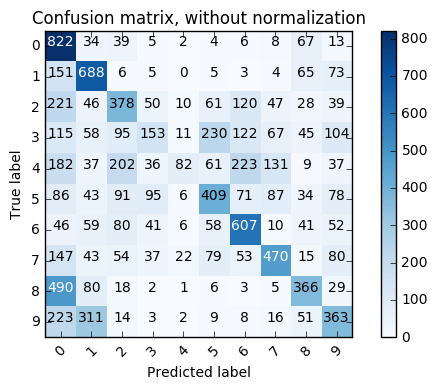

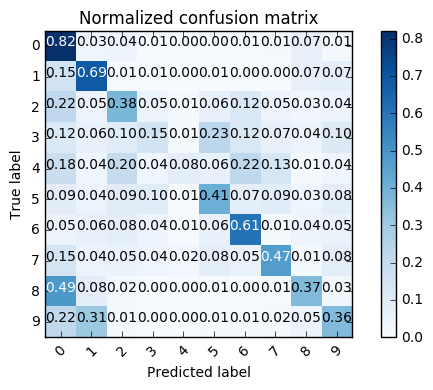

In [316]:
y_prediction = model.predict(x_test)
y_prediction_cls = np.argmax(y_prediction, axis=1)  # from one hot to class index
show_matrix(y_test, y_prediction_cls, [i for i in range(10)])

## 結論

###  under sampling
- クラス間の偏りはなくなる

### over sampling
- クラス間の偏りなくなる
- 精度が向上する


# over sampling with augmentation (need many epochs)